In [1]:
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
import pandas as pd
import numpy as np 
import scipy.stats as stats
from collections import Counter
import matplotlib.pyplot as plt
import umap
import matplotlib
%matplotlib inline
import pickle
import sklearn
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# import sentence_transformers
plt.style.use('ggplot')
#plt.style.use('seaborn-v0_8-dark-palette')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [2]:
gene_info_table = pd.read_csv("/Applications/LZY/WUR_Master_Internship/GenePT/gene_info_table.csv")
gene_info_table

,Unnamed: 0,ensembl_id,gene_name,gene_type
0,0,ENSG00000000003,TSPAN6,protein_coding
1,1,ENSG00000000005,TNMD,protein_coding
2,2,ENSG00000000419,DPM1,protein_coding
3,3,ENSG00000000457,SCYL3,protein_coding
4,4,ENSG00000000460,C1orf112,protein_coding
...,...,...,...,...
80524,80524,ENSGunknown_pk,pk,NaN
80525,80525,ENSGunknown_uc-338,uc-338,NaN
80526,80526,ENSGunknown_uc-338_1,uc-338.1,NaN
80527,80527,ENSGunknown_uc-338_2,uc-338.2,NaN


In [3]:
with open('/Applications/LZY/WUR_Master_Internship/GenePT/GenePT_gene_embedding_ada_text.pickle', "rb") as fp:
    GenePT_gene_embeddings = pickle.load(fp)

In [4]:
# Create random embeddings as negative controls
np.random.seed(2023)
N_DIM = 1536
fake_pretrain_embed = dict()
for key in GenePT_gene_embeddings.keys():
    fake_pretrain_embed[key] = np.random.normal(size=(N_DIM))

In [5]:
# Create a new column "gpt_embed" with default value as False
gene_info_table['gpt_embed'] = False

# Update the new column based on the condition
def check_embedding(row):
    gene = row['gene_name']
    if gene in GenePT_gene_embeddings:
        embed_value = GenePT_gene_embeddings[gene]
        if np.any(embed_value != 0):
            return True
    return False

gene_info_table['gpt_embed'] = gene_info_table.apply(check_embedding, axis=1)
# Create a subset where gpt_embed is True
subset = gene_info_table[gene_info_table['gpt_embed']]

# Find gene_type elements with occurrences > 50 (in this case, just for demonstration, I'll use > 2)
gene_type_counts = subset['gene_type'].value_counts()
common_gene_types = gene_type_counts[gene_type_counts > 75].index

# Create a final subset of the original DataFrame with only these gene_type elements
final_subset = gene_info_table[(gene_info_table['gene_type'].isin(common_gene_types))\
                               &(gene_info_table['gpt_embed'])]

# let's do a very simple classification for final_subset
X_list = []
y_list = []
# Iterate through rows of final_subset
for index, row in final_subset.iterrows():
    gene_name = row['gene_name']
    gene_type = row['gene_type']
    # Add the embedding from the dictionary to the x list
    if gene_name in GenePT_gene_embeddings:
        X_list.append(GenePT_gene_embeddings[gene_name])
    
    # Add the gene_type to the y list
        y_list.append(gene_type)

In [6]:
np.random.seed(2023)
from sklearn.model_selection import train_test_split

# Split the data into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_list, y_list, test_size=0.30, random_state=2023)

# Verify the split
print(f"Training set size (X_train): {len(X_train)}")
print(f"Test set size (X_test): {len(X_test)}")
# 1. Logistic Regression
lr = LogisticRegression(max_iter=100)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

Training set size (X_train): 23912
Test set size (X_test): 10249


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [7]:
sklearn.metrics.accuracy_score(y_pred_lr,y_test)

0.9348229095521514

In [45]:
# get expression 
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_normalized_confusion_matrix(y_true, y_pred, classes):
    """
    Plot a normalized confusion matrix using seaborn.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Normalize by row
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)  # replace nan with 0
    cm_normalized = cm_normalized * 100  # convert to percentage
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.0f', annot_kws={'fontsize': 13.5},
                cmap='Blues', xticklabels=classes, yticklabels=classes,cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

<Figure size 600x600 with 0 Axes>

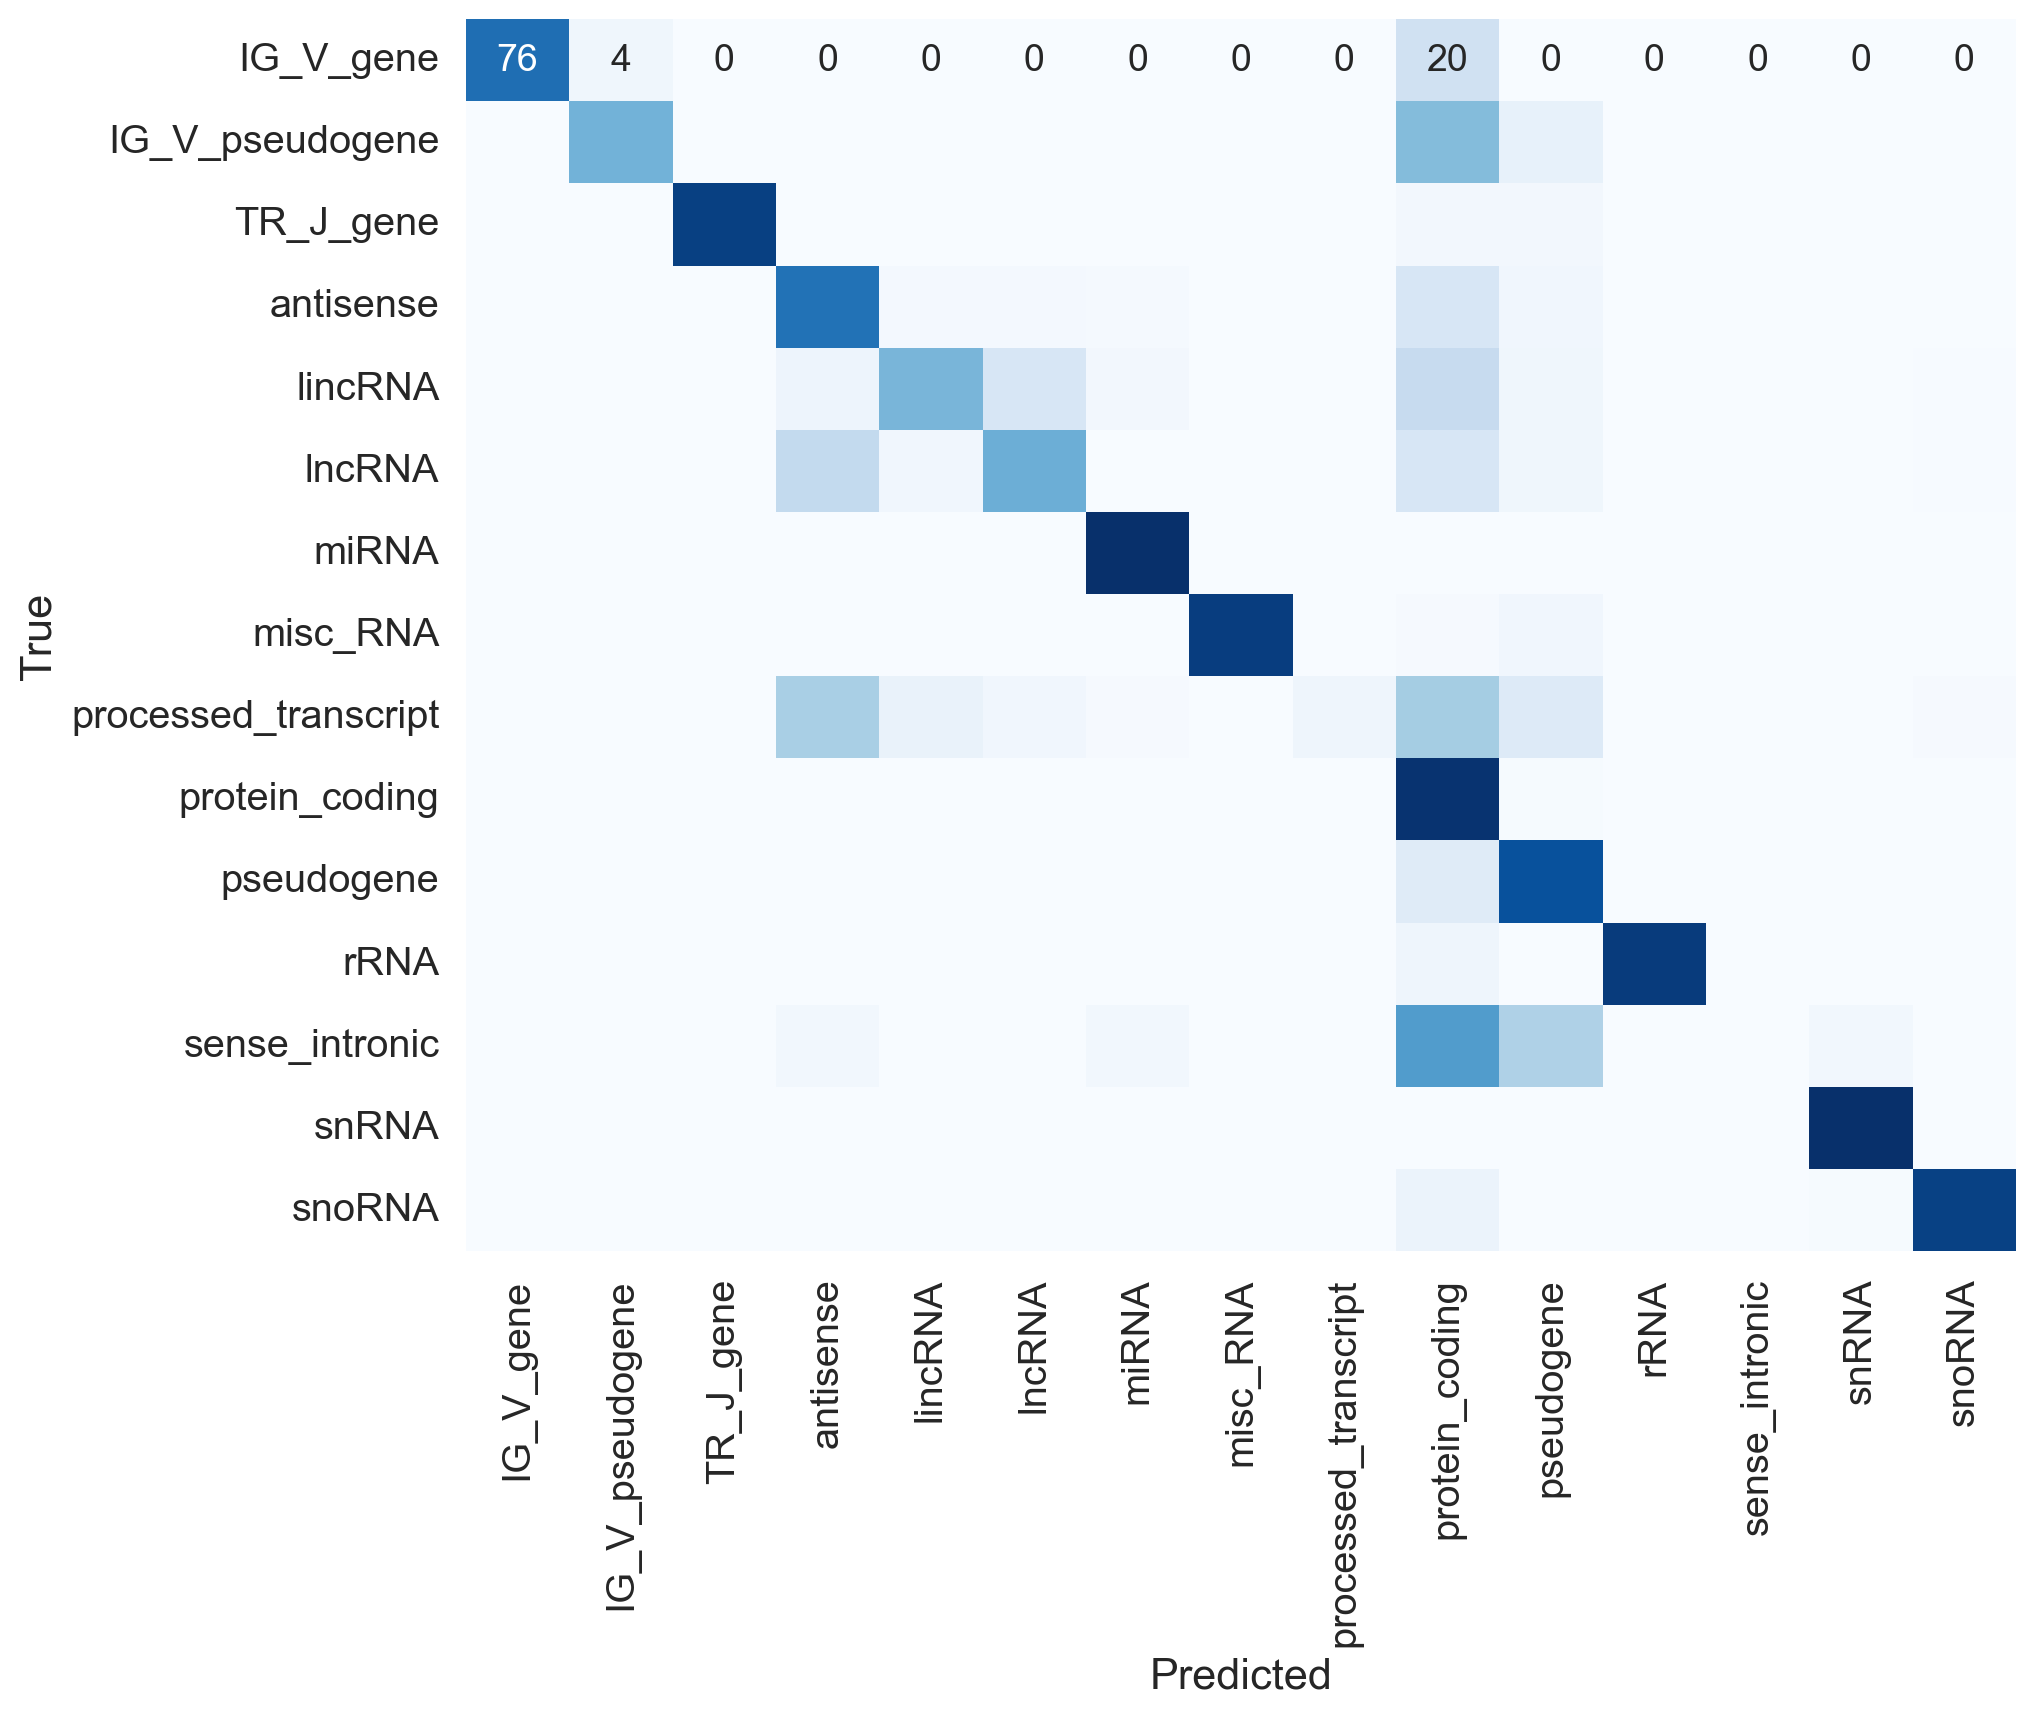

In [46]:
plt.rcParams.update({
    "text.usetex": False
})
plt.figure(figsize=(6,6))
sns.set(font_scale=1.3)
plot_normalized_confusion_matrix(np.array(y_test),y_pred_lr,np.unique(y_list))